## __Objective:__ Create a multiclass image classifier

## __Purpose:__ Can be used to classify  species of animal

### Use transfer learning and vgg16 model

### importing necessary libraries

In [1]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img 
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense 
from keras import applications 
from keras.utils.np_utils import to_categorical 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math 
import datetime
import time

Loading up our image datasets

In [2]:
#Default dimensions we found online
img_width, img_height = 224, 224  
   
#Create a bottleneck file
top_model_weights_path = 'bottleneck.h5' 

# loading up our datasets
train_data_dir = 'data_cards/train'  
validation_data_dir = 'data_cards/validation'  
test_data_dir = 'data_cards/test'
   
# number of epochs to train top model  
epochs = 7 #this has been changed after multiple model run  
# batch size used by flow_from_directory and predict_generator  
batch_size = 50  

In [3]:
#Loading vgc16 model
vgg16 = applications.VGG16(include_top=False, weights='imagenet') 

In [4]:
datagen = ImageDataGenerator(rescale=1. / 255)  #needed to create the bottleneck .npy files

# Creation of weights/features with VGG16

In [ ]:
#__this can take an hour and half to run so only run it once. 
#once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
   
generator = datagen.flow_from_directory(  
     train_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  
   
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train)  
   
np.save('bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

In [ ]:
print('-'*117)

---------------------------------------------------------------------------------------------------------------------


In [ ]:
#__this can take half an hour to run so only run it once. once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = vgg16.predict_generator(  
     generator, predict_size_validation)  
   
np.save('bottleneck_features_validation.npy', bottleneck_features_validation) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 1400 images belonging to 3 classes.


C:\Users\Daniel Carvalho\AppData\Local\Temp\ipykernel_15108\2798664618.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  bottleneck_features_validation = vgg16.predict_generator(


Time:  0:03:03.555399


In [ ]:
print('-'*117)

---------------------------------------------------------------------------------------------------------------------


In [ ]:
#__this can take half an hour to run so only run it once. once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     test_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_test_samples = len(generator.filenames)  
   
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
   
bottleneck_features_test = vgg16.predict_generator(  
     generator, predict_size_test)  
   
np.save('bottleneck_features_test.npy', bottleneck_features_test) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 22 images belonging to 3 classes.


C:\Users\Daniel Carvalho\AppData\Local\Temp\ipykernel_15108\143667794.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  bottleneck_features_test = vgg16.predict_generator(


Time:  0:00:02.905402


# Loading training, validation and testing data

In [5]:
#training data
generator_top = datagen.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes) 

Found 8051 images belonging to 3 classes.


In [6]:
#validation data
generator_top = datagen.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation.npy')  
   

validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)  

Found 1400 images belonging to 3 classes.


In [7]:
#testing data
generator_top = datagen.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('bottleneck_features_test.npy')  
   

test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 22 images belonging to 3 classes.


# Training of model

In [43]:
#This is the best model we found. For additional models, check out I_notebook.ipynb
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.5))  
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))  

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])  

history = model.fit(train_data, train_labels,  
      epochs=9,
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)
model.save("model.h5")  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Epoch 1/9


c:\Users\Daniel Carvalho\anaconda3\envs\CLasses\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


162/162 [==============================] - 5s 27ms/step - loss: 0.2033 - acc: 0.9319 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 2/9
162/162 [==============================] - 4s 26ms/step - loss: 0.0128 - acc: 0.9978 - val_loss: 0.0011 - val_acc: 0.9993
Epoch 3/9
162/162 [==============================] - 4s 26ms/step - loss: 0.0042 - acc: 0.9990 - val_loss: 4.3886e-05 - val_acc: 1.0000
Epoch 4/9
162/162 [==============================] - 4s 24ms/step - loss: 0.0021 - acc: 0.9996 - val_loss: 3.6905e-05 - val_acc: 1.0000
Epoch 5/9
162/162 [==============================] - 4s 24ms/step - loss: 7.2074e-04 - acc: 0.9999 - val_loss: 8.4237e-05 - val_acc: 1.0000
Epoch 6/9
162/162 [==============================] - 4s 26ms/step - loss: 8.1543e-04 - acc: 0.9998 - val_loss: 2.5499e-05 - val_acc: 1.0000
Epoch 7/9
162/162 [==============================] - 4s 25ms/step - loss: 4.4563e-04 - acc: 0.9999 - val_loss: 1.6693e-06 - val_acc: 1.0000
Epoch 8/9
162/162 [==============================] - 4

In [22]:
#Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 100)               2508900   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 153       
                                                                 
Total params: 2,514,103
Trainable params: 2,514,103
Non-

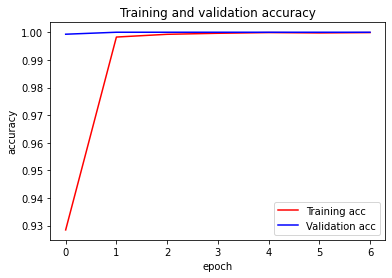

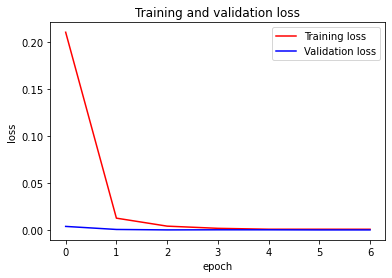

In [23]:
#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

## Model Evaluation on Testing Set

In [24]:
model.evaluate(test_data, test_labels)

1/1 [==============================] - 0s 21ms/step - loss: 2.5467e-07 - acc: 1.0000


[2.5467417685831606e-07, 1.0]

## Classification metrics and Confusion Matrix

### Classification Metrics

In [25]:
print('test data', test_data)
preds = np.round(model.predict(test_data),0) 
#to fit them into classification metrics and confusion metrics, some additional modificaitions are required
print('rounded test_labels', preds)

test data [[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    6.21061921e-02 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]]

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 8.96797657e-01 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [4.59595084e-01 0.00000000e+00 5.87567091e-01 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 8.96587610e-0

In [26]:
classes = ['MAGIC', 'MONSTER', 'TRAP']
classification_metrics = metrics.classification_report(test_labels, preds, target_names=classes )
print(classification_metrics)

              precision    recall  f1-score   support

       MAGIC       1.00      1.00      1.00        12
     MONSTER       0.00      0.00      0.00         0
        TRAP       1.00      1.00      1.00        10

   micro avg       1.00      1.00      1.00        22
   macro avg       0.67      0.67      0.67        22
weighted avg       1.00      1.00      1.00        22
 samples avg       1.00      1.00      1.00        22



c:\Users\Daniel Carvalho\anaconda3\envs\CLasses\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Daniel Carvalho\anaconda3\envs\CLasses\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Confusion Matrix

In [27]:
#Since our data is in dummy format we put the numpy array into a dataframe and call idxmax axis=1 to return the column
# label of the maximum value thus creating a categorical variable
#Basically, flipping a dummy variable back to it's categorical variable
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

In [28]:
confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)

TypeError: 'numpy.ndarray' object is not callable

In [29]:
#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
#     print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization


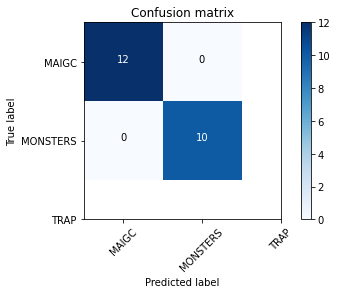

In [30]:
plot_confusion_matrix(confusion_matrix, ['MAIGC', 'MONSTERS', 'TRAP'])

Normalized confusion matrix


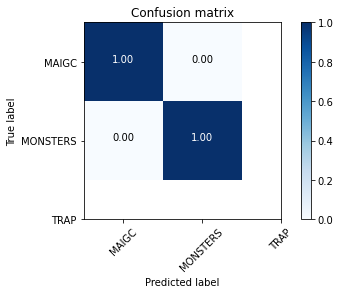

In [31]:
#Those numbers are all over the place. Now turning normalize= True
plot_confusion_matrix(confusion_matrix, 
                      ['MAIGC', 'MONSTERS', 'TRAP'],
                     normalize=True)

## Testing images on model

In [32]:
def read_image(file_path):
    print("[INFO] loading and preprocessing image...")  
    image = load_img(file_path, target_size=(224, 224))  
    image = img_to_array(image)  
    image = np.expand_dims(image, axis=0)
    image /= 255.  
    return image

In [33]:
def test_single_image(path):
    classes = ['MAGIC', 'MONSTERS', 'TRAP']
    images = read_image(path)
    time.sleep(.5)
    bt_prediction = vgg16.predict(images)  
    preds = model.predict(bt_prediction)
    for idx, type, x in zip(range(0,6), classes , preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, type, round(x*100,2) ))
    print('Final Decision:')
    time.sleep(.5)
    for x in range(3):
        print('.'*(x+1))
        time.sleep(.2)
    class_predicted = model.predict(bt_prediction)
    class_dictionary = generator_top.class_indices  
    inv_map = {v: k for k, v in class_dictionary.items()}  
    #print("ID: {}, Label: {}".format(class_predicted[0], inv_map[class_predicted[0]]))  
    return load_img(path)

In [41]:
path = r'C:\Users\Daniel Carvalho\Desktop\CARDS\14121580.jpg'

[INFO] loading and preprocessing image...
1/1 [==============================] - 0s 81ms/step
ID: 0, Label: MAGIC 0.0%
ID: 1, Label: MONSTERS 100.0%
ID: 2, Label: TRAP 0.0%
Final Decision:
.
..
...
1/1 [==============================] - 0s 21ms/step


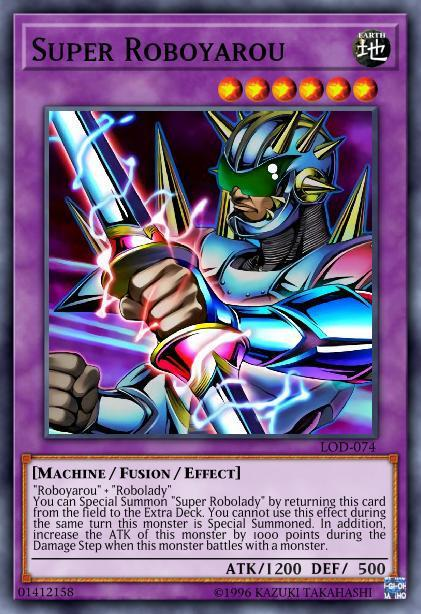

In [42]:
test_single_image(path)

[INFO] loading and preprocessing image...
1/1 [==============================] - 0s 50ms/step
ID: 0, Label: MAGIC 0.0%
ID: 1, Label: MONSTERS 100.0%
ID: 2, Label: TRAP 0.0%
Final Decision:
.
..
...
1/1 [==============================] - 0s 18ms/step


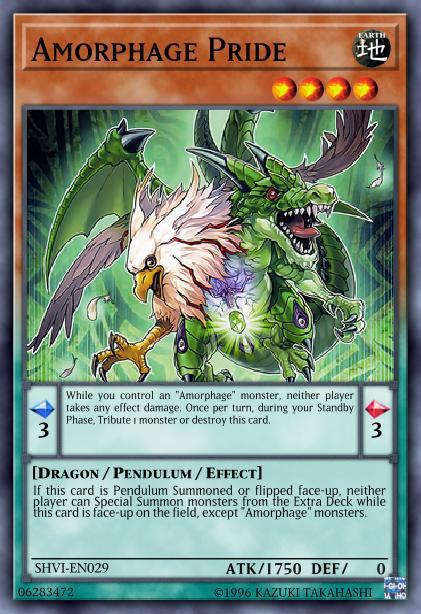

In [38]:
from tensorflow.keras.models import load_model
model = load_model('model.h5')
test_single_image(path)

In [39]:
def test_single_image(path):
    classes = ['MAGIC', 'MONSTERS', 'TRAP']
    images = read_image(path)
    time.sleep(.5)
    bt_prediction = vgg16.predict(images)  
    preds = model.predict(bt_prediction)
    for idx, type, x in zip(range(0,6), classes , preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, type, round(x*100,2) ))
    print('Final Decision:')
    time.sleep(.5)
    for x in range(3):
        print('.'*(x+1))
        time.sleep(.2)
    class_predicted = model.predict(bt_prediction)
    #class_dictionary = generator_top.class_indices  
    #inv_map = {v: k for k, v in class_dictionary.items()}  
    #print("ID: {}, Label: {}".format(class_predicted[0], inv_map[class_predicted[0]]))  
    return load_img(path)

[INFO] loading and preprocessing image...
1/1 [==============================] - 0s 15ms/step
ID: 0, Label: MAGIC 0.0%
ID: 1, Label: MONSTERS 100.0%
ID: 2, Label: TRAP 0.0%
Final Decision:
.
..
...
1/1 [==============================] - 0s 17ms/step


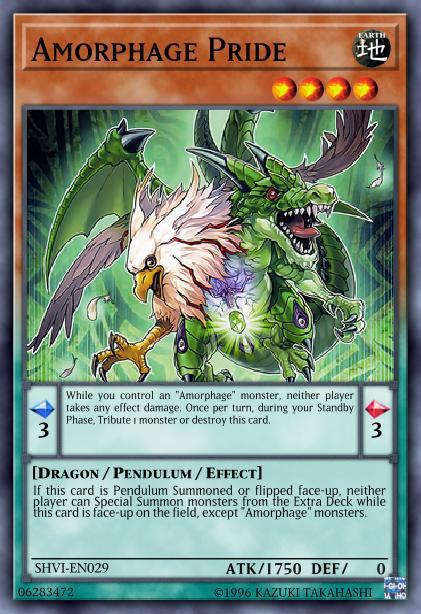

In [40]:
test_single_image(path)

In [44]:
a = pd.read_csv('finaldata.csv')
a

,id,name,type,race,archetype,atk,def,level,cardmarket,tcgplayer,ebay,amazon,coolstuffinc
0,34541863,A Cell Breeding Device,Spell Card,Continuous,Alien,0,0,0,0.14,0.19,1.29,24.45,0.25
1,64163367,A Cell Incubator,Spell Card,Continuous,Alien,0,0,0,0.09,0.20,1.15,0.50,0.25
2,91231901,A Cell Recombination Device,Spell Card,Quick-Play,Alien,0,0,0,0.21,0.23,0.99,0.50,0.49
3,73262676,A Cell Scatter Burst,Spell Card,Quick-Play,Alien,0,0,0,0.12,0.10,0.99,9.76,0.25
4,37478723,Infernoble Arms - Durendal,Spell Card,Equip,Noble Knight,0,0,0,0.32,0.21,0.99,2.96,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12129,2648201,ZW - Sleipnir Mail,Effect Monster,Beast,Utopia,1000,1000,4,0.10,0.26,0.99,0.49,0.99
12130,95886782,ZW - Sylphid Wing,Effect Monster,Beast,Utopia,800,1600,4,0.06,0.07,0.99,0.30,0.49
12131,81471108,ZW - Tornado Bringer,Effect Monster,Dragon,Utopia,1300,1800,5,0.09,0.07,0.99,1.23,0.49
12132,18865703,ZW - Ultimate Shield,Effect Monster,Aqua,Utopia,0,2000,4,0.03,0.04,1.09,0.20,0.49


In [60]:
def test_single_image(path):
    classes = ['MAGIC', 'MONSTERS', 'TRAP']
    images = read_image(path)
    time.sleep(.5)
    bt_prediction = vgg16.predict(images)  
    preds = model.predict(bt_prediction)
    a = []
    for idx, type, x in zip(range(0,6), classes , preds[0]):
        a.append([("ID: {}, Label: {} {}%".format(idx, type, round(x*100,2) ))])
    return a
    #print('Final Decision:')
    #time.sleep(.5)
    #for x in range(3):
        #print('.'*(x+1))
        #time.sleep(.2)
    #class_predicted = model.predict(bt_prediction)
    #class_dictionary = generator_top.class_indices  
    #inv_map = {v: k for k, v in class_dictionary.items()}  
    #print("ID: {}, Label: {}".format(class_predicted[0], inv_map[class_predicted[0]]))  
    return a

In [61]:
test_single_image(r'C:\Users\Daniel Carvalho\Desktop\CARDS\aa.jpeg')

[INFO] loading and preprocessing image...
1/1 [==============================] - 0s 13ms/step


[['ID: 0, Label: MAGIC 0.0%'],
 ['ID: 1, Label: MONSTERS 100.0%'],
 ['ID: 2, Label: TRAP 0.0%']]